***Matthew Spinelli***

Due Oct 31, 2017

This is my second time playing around with Kaggle, having first followed some tutorials with regards the titanic dataset at the start of this year (although I wasn't able to deviate too far from those tutorials since I was realatively new to machine learning at the time). I'm now taking a graduate machine learning course and we were given the option of using the titanic dataset or this one for a project, so I wanted to do something different and more challenging as this is a multi-class classification problem!

While I am very familiar with python as a language, I'm not too familiar with *pandas* and  *matplotlib* (or *seaborn*) having more background in R for data wrangling, visualization, and some statistical methods (even though I dislike R for general purpose programming). As such, I'll be importing *plotnine* which is a pretty good port of Hadley Wickham's excellent *ggplot2* package. I'll also drop down into *matplotlib* where I can repurpose code I've used in the course already. I was going to also use *Dplython*, a port of Wickham's *Dplyr* but this doesn't seem to be supported by Kagge's Kernels at this time. I'll take this as an oppurtunity to learn more about *pandas* and see how I like wranging data with it.

In [34]:
%pylab inline
import pandas as pd
from plotnine import *

Populating the interactive namespace from numpy and matplotlib


/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['arrow', 'test', 'datetime', 'xlim', 'annotate', 'ylim', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


To start let's import the training data and take a look at it's structure as it's a good idea to understand the data first before throwing classifiers at it.

In [35]:
df = pd.read_csv('train.csv.gz', compression='gzip')
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


How many animal types do we have and how are the outcome types distributed among each of the animal types?

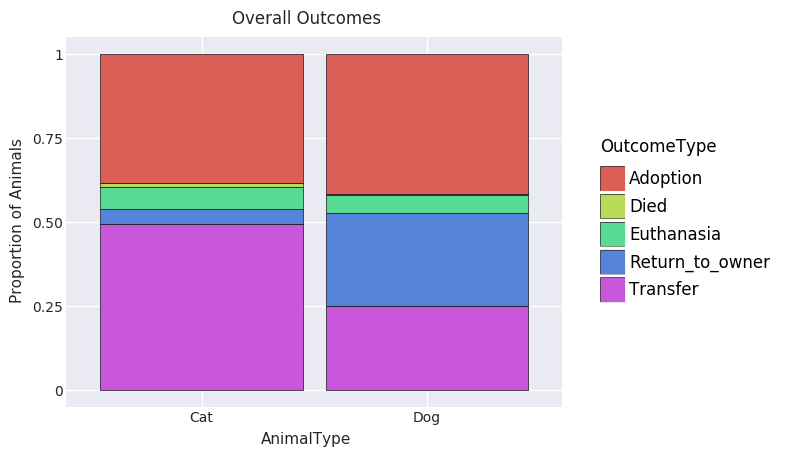

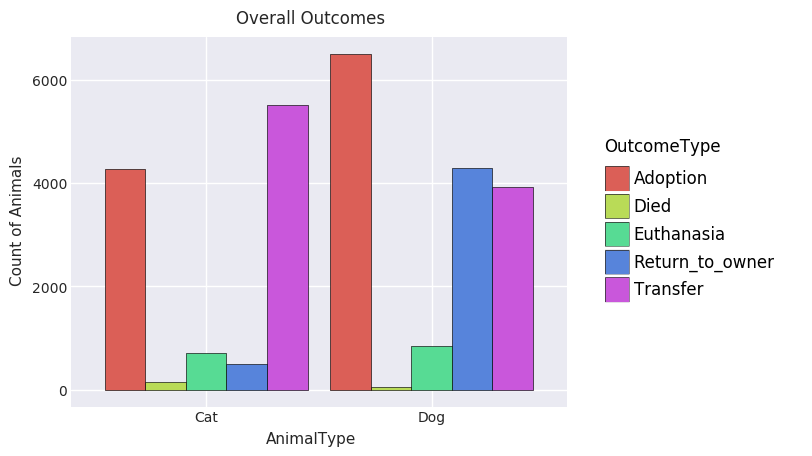

[<ggplot: (300961165)>, <ggplot: (-9223372036553816302)>]

In [36]:
plots = []
for position, label in [('fill', 'Proportion'), ('dodge', 'Count')]:
    plots.append(
        ggplot(df, aes(x = 'AnimalType', fill = 'OutcomeType'))
        + geom_bar(position = position, color = 'black', size=.25)
        + labs(y = '{} of Animals'.format(label), title ='Overall Outcomes')
        + theme_seaborn())
plots

So it seems there are only two animal types (cats, and dogs). Additionally, the distribution of outcomes are different between the two groups, most notably are the proportion of cats that get transfered instead of returned to their owners (compared to dogs). Let's look at these outcomes in a bit more detail crossed by some other features, starting first with SexuponOutcome.

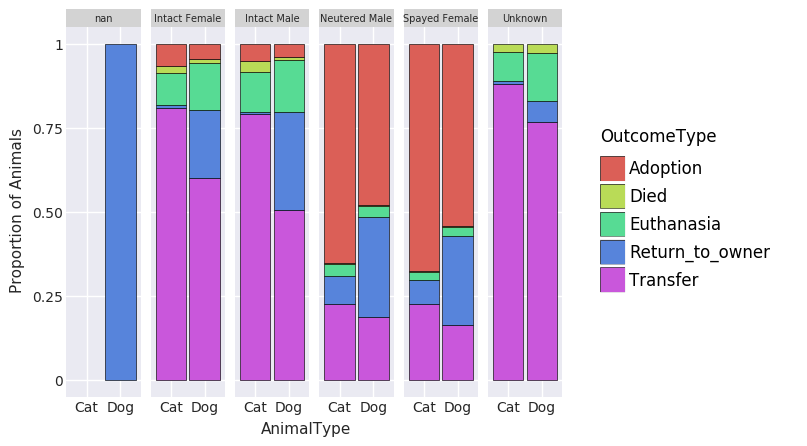

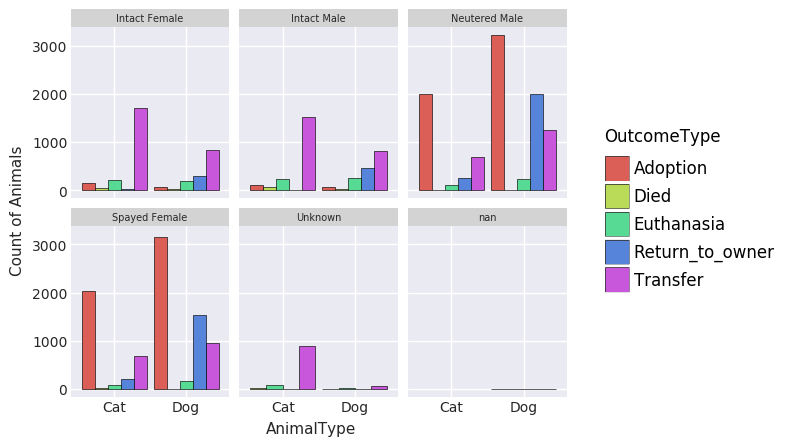

[<ggplot: (-9223372036544487771)>, <ggplot: (-9223372036544487883)>]

In [37]:
plots = []
for i, (position, label) in enumerate([('fill', 'Proportion'), ('dodge', 'Count')]):
    p = (ggplot(df, aes(x = 'AnimalType', fill = 'OutcomeType'))
        + geom_bar(position = position, color = 'black', size=.25)
        + labs(y = '{} of Animals'.format(label))
        + theme_seaborn()
        + theme(strip_text_x = element_text(size = 7)))
    if i == 0:
        plots.append(p + facet_grid('. ~ SexuponOutcome'))
    else:
        plots.append(p + facet_wrap('SexuponOutcome'))
plots

* Now this is interesting, the distributions in terms of relative outcome proprotions and animal popultion are vastly different if the animals are spayed or neutered. Also it's interesting to see that none in the category seem *Unknown* to have been adopted. Furthermore, very few dogs of unknown sex/genetial status seem to be in the dataset.  First let's take care fo the **NaN** values. How many are there? It doesn't seem like there are many judging by the graphs.

In [38]:
df[df.SexuponOutcome.isnull()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle


Alright, the most sensible thing here to do is to just change it to join the unknown class.

In [39]:
df.loc[3174].SexuponOutcome = 'Unknown'

Now, let's deal with the state of the genitalia for the pets by creating a new feature called *Genitals* to store whether they are intact or neutered (technically neutered refers to either sex so it's an appropriate label here as castration would be the male only term -- at least according to wikipedia). Also, we will seperate out the sex into a feature as well.

In [40]:
M, F, U = 'Male', 'Female', 'Unknown'
def extract_sex(x):
    return M if M in str(x) else F if F in str(x) else U

N, S, I = 'Neutered', 'Spayed', 'Intact'    
def extract_genitals(x):
    return N if (N in str(x) or S in str(x)) else I if I in str(x) else U

df['Sex'] = df.SexuponOutcome.apply(extract_sex)
df['Genitals'] = df.SexuponOutcome.apply(extract_genitals)
 
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Sex,Genitals
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Male,Neutered
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Female,Neutered
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Male,Neutered
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Male,Intact
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Male,Neutered


In the plots above we can see some differences in gender between intact and neutered genitals. Below are the plots of the new features seperately and they emphasize again how much it matters for better outcomes for the pets if they have been neutered. Further, we can also see again the difference between a transfer outcome and return to owner outcome (something noted at the beginning) seems to be captured pretty well by this feature when comparing cats vs. dogs. The difference in sex doesn't seem to matter much other than if you're a dog it helps to be female if you want to be adopted.

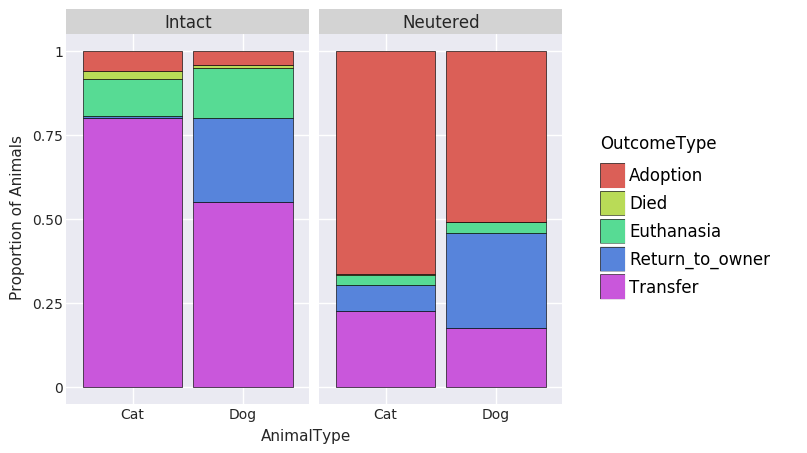

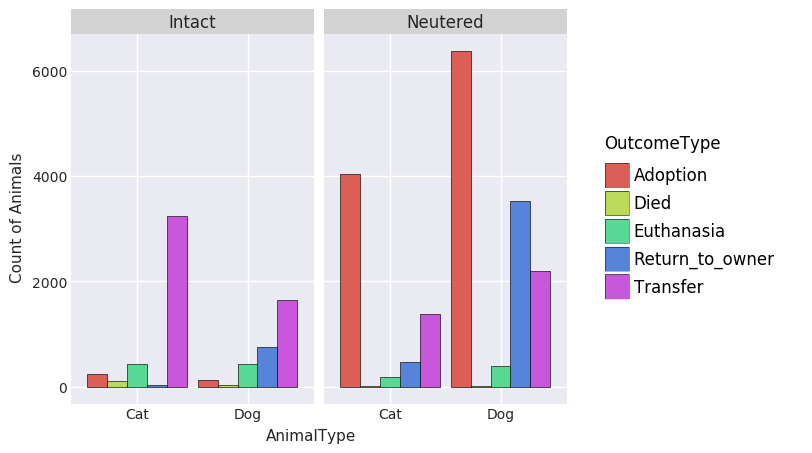

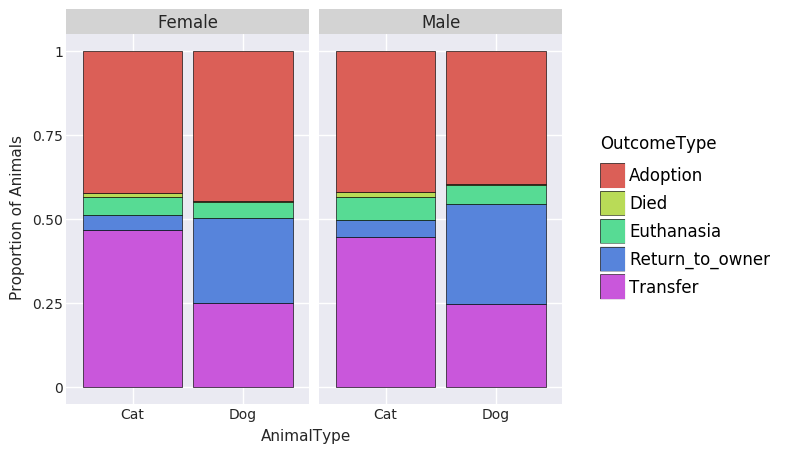

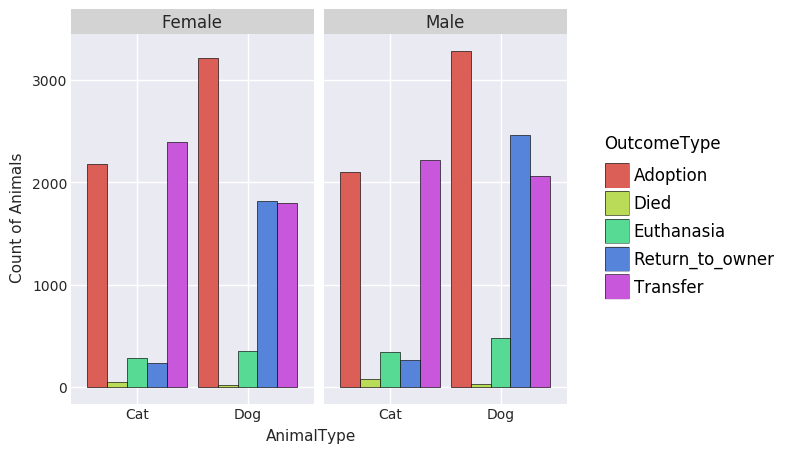

[<ggplot: (303331318)>,
 <ggplot: (309803440)>,
 <ggplot: (-9223372036542366320)>,
 <ggplot: (-9223372036544763234)>]

In [41]:
plots = []
for category in ['Genitals', 'Sex']:
    for position, label in [('fill', 'Proportion'), ('dodge', 'Count')]:
        plots.append(
            ggplot(df[df.SexuponOutcome != 'Unknown'], 
                   aes(x = 'AnimalType', fill = 'OutcomeType'))
            + geom_bar(position = position, color = 'black', size=.25)
            + facet_wrap(category)
            + labs(y = '{} of Animals'.format(label))
            + theme_seaborn())
plots

We still have some other features to look at, such as Age and this one is ugly as it's in four different units of measure (days, weeks, months, and years) -- plus they overlap.

In [42]:
df.AgeuponOutcome.unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

Before anything let's normalize these values into a single unit of measure (AgeInDays) as this really is continous data and not discrete (even though it's measured in discrete chunks and we can deal with that visually as we'll see in a second by choosing appropriate bin sizes for histograms). Also AgeInDays avoids factrions which is nice. With the **NaN** values we'll deal with those later but will check to see how many there are, but for now let's transform the data and begin to visualize it.

NaN count 18


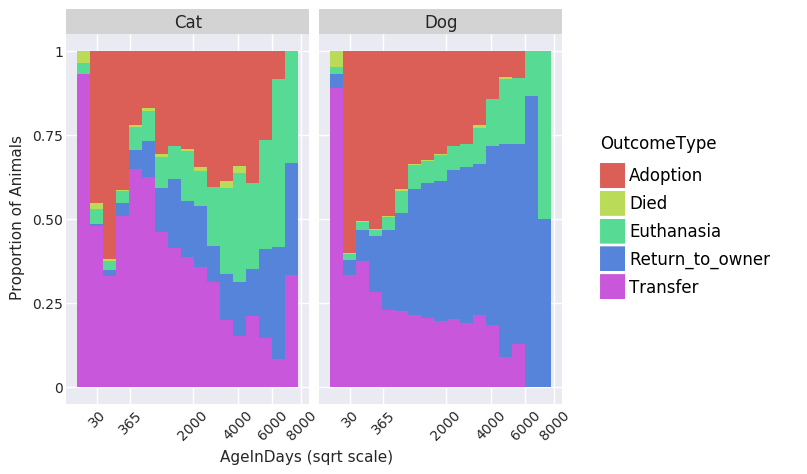

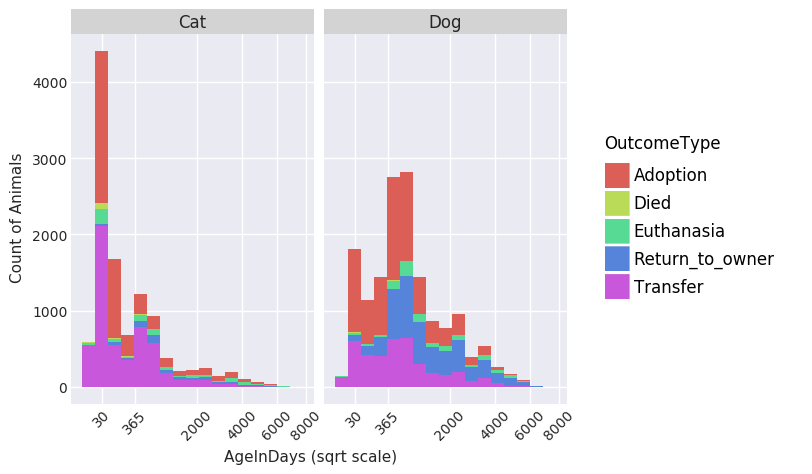

[<ggplot: (294629601)>, <ggplot: (-9223372036560108337)>]

In [43]:
print("NaN count", len(df[df.AgeuponOutcome.isnull()]))

def convert_to_AgeInDays(x):
    if x is np.nan:
        return x
    numeric_portion, unit = str(x).split(' ')
    factor = {'year': 365, 'month': 30, 'week': 7, 'day': 1}
    return int(numeric_portion) * factor[unit.replace('s','')]

df['AgeInDays'] = df.AgeuponOutcome.map(convert_to_AgeInDays)

plots = []
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    plots.append(
        ggplot(df[df.AgeInDays.notnull()], 
               aes(x = 'AgeInDays', fill ='OutcomeType'))
        # bins=17 highest we can go without breaking up
        + geom_bar(stat = 'bin', bins=17, position=position) 
        + scale_x_sqrt(breaks=[30, 365, 2000, 4000, 6000, 8000])
        + labs(y = '{} of Animals'.format(label),
               x = 'AgeInDays (sqrt scale)')
        + theme_seaborn()
        + facet_wrap('~AnimalType')
        + theme(axis_text_x = element_text(angle = 45))
    )
plots

The plots above have the x-scale under a square-root transformation. This is helpful because we have a lot of animals that are young and not so many that are very old.  This kind of scaling makes it easier to see both without either overwhelming the plot. 

There also appears to be a trend after about 30 days an animal is more likely to be adopted but that gradually decreases with age (more so for dogs than cats). Getting transfered seems to have a relationship in the same direction with adoption overtime as well, while return to user and euthanasia has an inverse relationship (this is more clearly seen in the plots for dogs). Next let's zoom in to visualize these trends and others by targeting more specific time based on the inital time frames (days, weeks, months, years). So let's look at those too. But one things seems promising here: *AgeInDays* looks like a good feature to learn from.

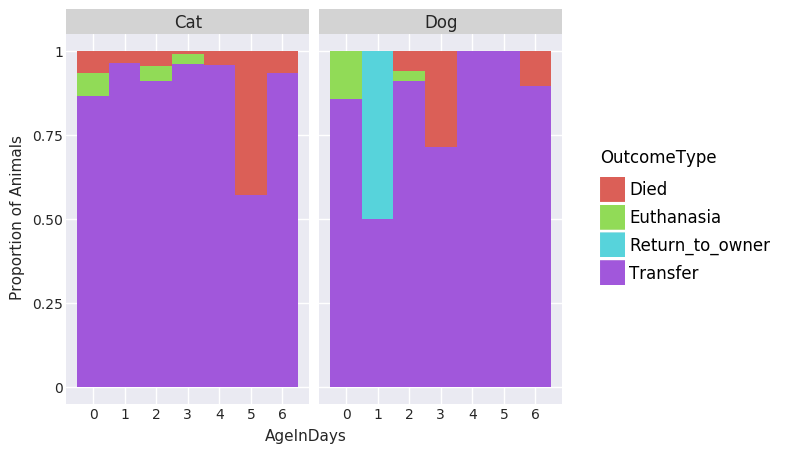

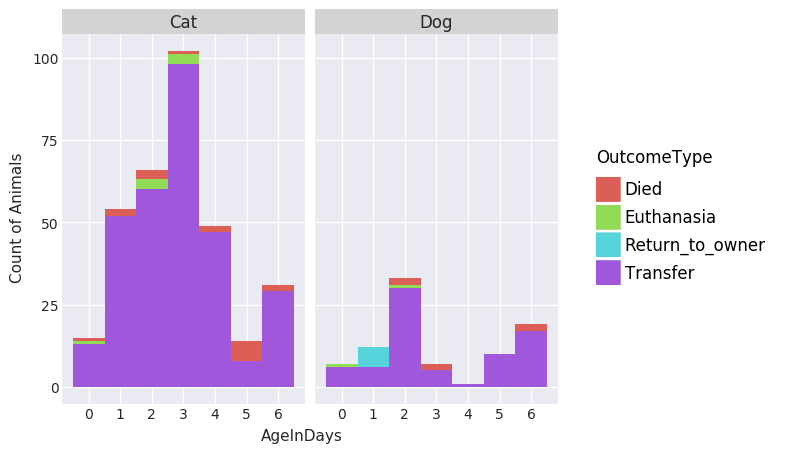

[<ggplot: (294629489)>, <ggplot: (294666223)>]

In [44]:
plots = []
daylings = df[df.AgeInDays < 7]
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    plots.append(
        ggplot(daylings, aes(x = 'AgeInDays', fill ='OutcomeType'))
        + geom_bar(stat = 'bin', bins=7, position=position)
        + scale_x_continuous(breaks=[x for x in range(7)])
        + labs(y = '{} of Animals'.format(label))
        + facet_wrap('~AnimalType')
        + theme_seaborn()
    )
plots

The sample sizes in each bin (day) above seems a bit low in many cases (especially for dogs), this might be an issue for when the data is split into multiple training and validation folds. The most common thing at this stage is for a transfer outcome, although dying also is fairly high (note that there is no adoption in this stage and the red color is now used for died). So after seeing how things go we might want to split the data into new categories instead of relying on AgeInDays directly. Let's keep this in mind as we continue.

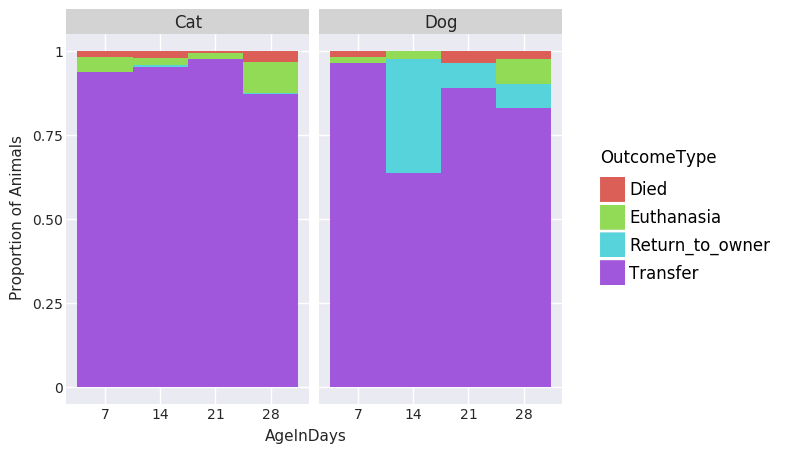

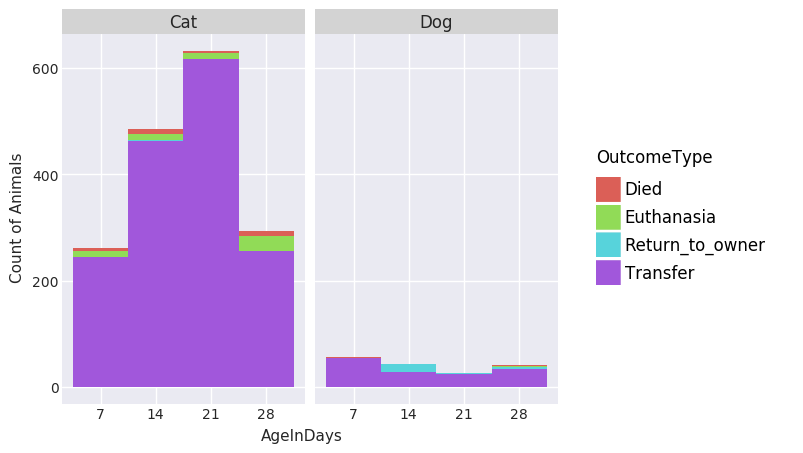

[<ggplot: (303335558)>, <ggplot: (314858451)>]

In [45]:
plots = []
weeklings = df[df.AgeInDays.between(7, 28)]
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    plots.append(
        ggplot(weeklings, aes(x = 'AgeInDays', fill ='OutcomeType'))
        + geom_bar(stat = 'bin', bins=4, position=position)
        + scale_x_continuous(breaks=[7, 14, 21, 28])
        + labs(y = '{} of Animals'.format(label))
        + facet_wrap('~AnimalType')
        + theme_seaborn()
    )
plots

In weeks 1-4 shown we have a bit more data, but it still has some low sample sizes for dog. So again this might be problematic. But regardless, these plots look similar to the ones before where the transfer outcome has the highest proprotion among the population along with many animals passing away. Starting out might be a bit of a dangerous time for new potential pets. Perhaps a new feature we might want to make is a category for "New Born" defining them as 4 weeks old or less to try and capture some of this while keeping sample sizes fairly high. Let's keep that in mind for later. 

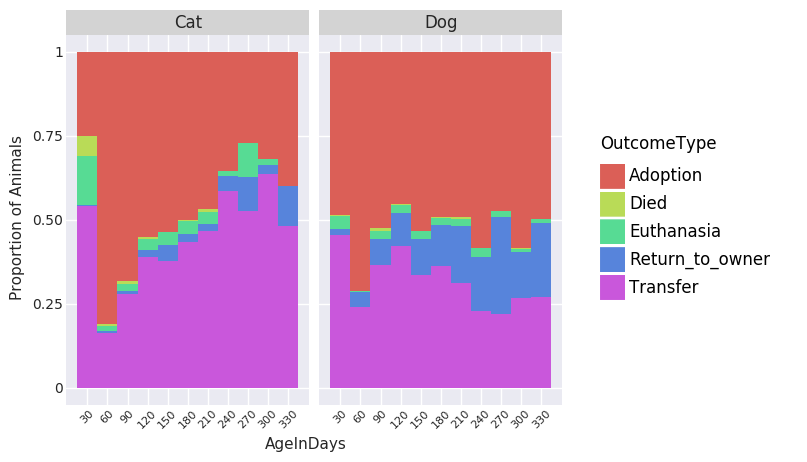

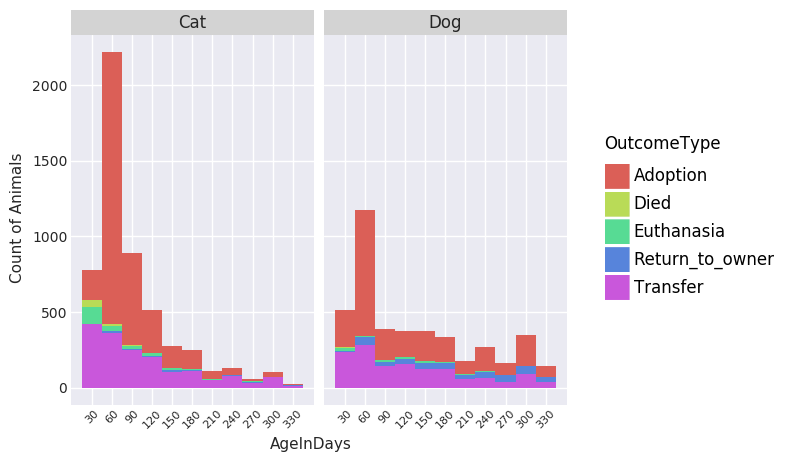

[<ggplot: (313273962)>, <ggplot: (313285331)>]

In [46]:
plots = []
monthlings =  df[df.AgeInDays.between(30, 360)]
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    plots.append(
        ggplot(monthlings, aes(x = 'AgeInDays', fill ='OutcomeType'))
        + geom_bar(stat = 'bin', bins=11, position=position)
        + scale_x_continuous(breaks=[(x+1)*30 for x in range(11)])
        + labs(y = '{} of Animals'.format(label))
        + facet_wrap('~AnimalType')
        + theme_seaborn()
        + theme(axis_text_x = element_text(angle = 45, size = 8))
    )
plots

Considering that dying is very rare in this data set and there is farily large sample size around the 30 day mark, it looks suspcious that so many cats died around the 30 day mark (which recall probably includes both 1-month and 5-weeks in the original data categories as we've accounted for 4-weeks in the earlier plots). I'm not sure why this is, but looking at the earlier plot of AgeInDays overall this might also be the age where both the greatest number of cats die and at the largest proportionaly.  Similarly, euthanasia is also very high. 

So once again, it might be useful to make a feature, say *Milestone* to capture not just the "New Born" stage of days 0-28, but also another for the 29-35 day range (there isn't anything in this data other than at 30 and 35 days as shown below).  If I were to guess I'd imagine that many animals might have health issues this young and end up getting euthanazied to put them out of their misery if they have trouble making it to the 1-month mark. This doesn't explain why the grim reaper vists so many animals without the doctor's assistence (die outcome) at the 30 day mark though -- weird (and sad). So perhaps this milestone could be called the "Early Culling".  Also in this stage of < 1 year we see some of the highest adoption rates. So we could call the period between 36-364 days the "Prime Adoption" milestone.

Again, we'll explore this kind of feature engineering later so just make note of it for now as I want to see how a logistic regression will handle the data using some simpler features first. I have no idea if it will help, which is another reason I want to move on for now and try using just *AgeInDays*.

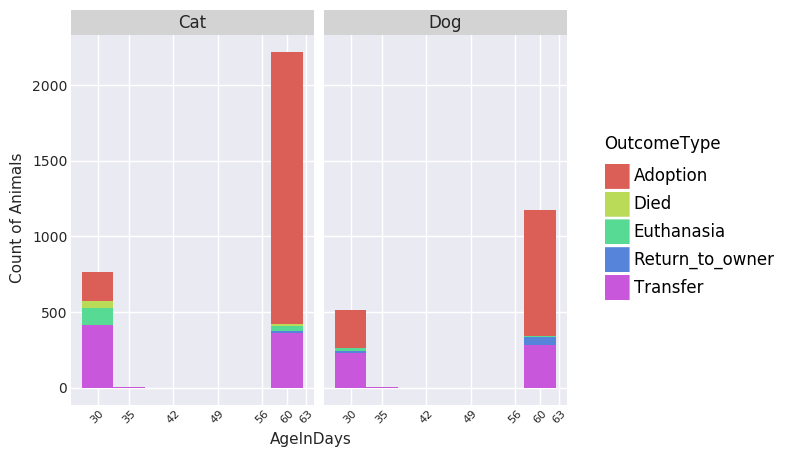

<ggplot: (-9223372036548235204)>

In [47]:
culling =  df[df.AgeInDays.between(29, 63)]
(ggplot(culling, aes(x = 'AgeInDays', fill ='OutcomeType'))
 + geom_bar(stat = 'bin', bins=7, position='stack')
 + scale_x_continuous(breaks=[30, 35, 42, 49, 56, 60, 63])
 + labs(y = 'Count of Animals')
 + facet_wrap('~AnimalType')
 + theme_seaborn()
 + theme(axis_text_x = element_text(angle = 45, size = 8)))

Now let's look at our last of the origional groups (remember they were: days, weeks, months, years).

/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/plotnine/positions/position_stack.py:99: RuntimeWarning: invalid value encountered in true_divide
  heights = heights / np.abs(heights[-1])
/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/plotnine/layer.py:458: UserWarning: geom_bar : Removed 5 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


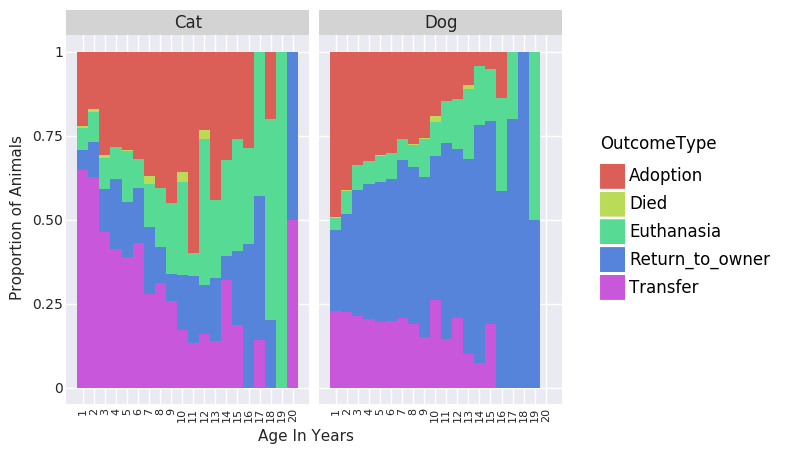

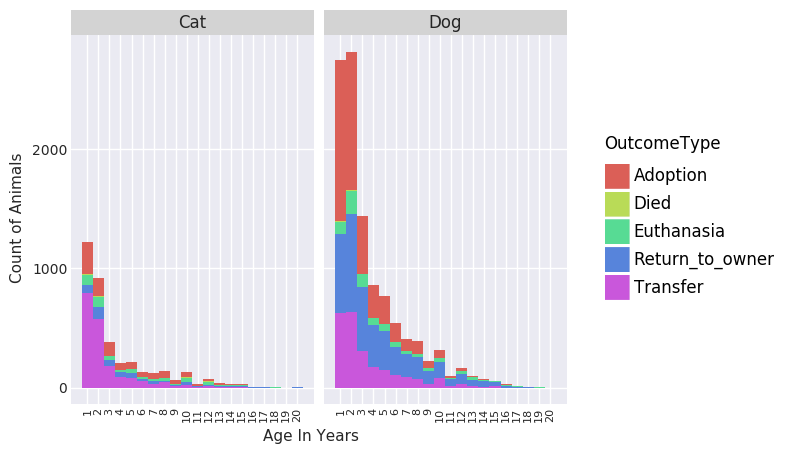

[<ggplot: (-9223372036560036159)>, <ggplot: (313278454)>]

In [48]:
plots = []
yearlings =  df[df.AgeInDays > 360]
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    plots.append(
        ggplot(yearlings, aes(x = 'AgeInDays', fill ='OutcomeType'))
        + geom_bar(stat = 'bin', bins=20, position=position)
        + scale_x_continuous(breaks=[(x+1)*365 for x in range(20)],
                             labels=[int((x+1)*365/365) for x in range(20)])
        + labs(y = '{} of Animals'.format(label),
               x = 'Age In Years')
        + facet_wrap('~AnimalType')
        + theme_seaborn()
        + theme(axis_text_x = element_text(angle = 90, size = 8))
    )
plots

So it turns out we have a lot more dogs in this age group than cats and the general trend talked about in the very first of these plots holds (adoption and transfer rates decrease with time while euthanasia and return to owner increase). Also, there appears to be a spike in non-euthanized deaths at 7, 10, and 11 years for cats and 10 and 13 years for dogs. These years seem to be the mid points for these animals. Perhaps a midlife crisis is leading to some dangerous behavior in the animal shelters. 

Three more *Milestone* categories thus could be made: "Youth" (1-6 years), "Midlife" (7-13), and "Old Age" (14+); in addition to the other categories: "New Born" (0-28 days), "Early Culling" (29-35 days)", and "Prime Adoption" (36-364 days).

Now let's deal with the **18** NaN values for the age. We'll use sklearn's Imputer for this and then train the classifiers and see how they cross validate.

In [49]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median') # statsmodel.sandbox.MICE isn't avilable on kaggle

# seems not to work properly with something that isn't an integer, 
# so a good reason to make AgeInDays
# df.AgeuponOutcome = imputer.fit_transform(pd.get_dummies(df.loc[:, ['AgeuponOutcome']]))
df.AgeInDays = imputer.fit_transform(pd.get_dummies(df.loc[:, ['AgeInDays']]))

Since neutering seems to have a noticable differnce visually, as does age, I'm eager to start fiting a model to the data. So let's see how well a logistic regression performs with four features (AnimalType, Sex, Genitals, and AgeInDays). We can then later go back to doing more data exploration, data wrangling, and maybe some feature engineering to improve the results (or try other methods/classifiers). First, let's split the data into multiple training and validation sets using sklearn's stratified k-fold method to ensure we have a proportional amount of examples of each outcome per fold.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core import display as ICD

def create_train_validate_sets(df, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=12345)
    t = df.OutcomeType
    train, validate = [], []
    for train_index, validate_index in skf.split(np.zeros(len(t)), t):
        train.append(df.loc[train_index])
        validate.append(df.loc[validate_index])
    return train, validate

n_folds = 10
train, validate = create_train_validate_sets(df, n_folds)

print('Total number of samples:', len(df), '\n')
print('Training sample size per fold:')
summary = pd.DataFrame([
    f.groupby('OutcomeType')
    .count()
    .AnimalID.rename('Fold {}'.format(i+1)) 
    for i, f in enumerate(train)])
summary['Any'] = summary.sum(axis=1)
summary.columns = summary.columns.rename('')
ICD.display(summary)

print('Validation samples per fold:')
summary = pd.DataFrame([
    f.groupby('OutcomeType')
    .count()
    .AnimalID.rename('Fold {}'.format(i+1)) 
    for i, f in enumerate(validate)])
summary['Any'] = summary.sum(axis=1)
summary.columns = summary.columns.rename('')
ICD.display(summary)

Total number of samples: 26729 

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,9692,177,1399,4307,8479,24054
Fold 2,9692,177,1399,4307,8479,24054
Fold 3,9692,177,1399,4307,8480,24055
Fold 4,9692,177,1399,4307,8480,24055
Fold 5,9692,177,1399,4307,8480,24055
Fold 6,9692,177,1400,4307,8480,24056
Fold 7,9692,177,1400,4308,8480,24057
Fold 8,9692,178,1400,4308,8480,24058
Fold 9,9692,178,1400,4308,8480,24058
Fold 10,9693,178,1400,4308,8480,24059


Validation samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1077,20,156,479,943,2675
Fold 2,1077,20,156,479,943,2675
Fold 3,1077,20,156,479,942,2674
Fold 4,1077,20,156,479,942,2674
Fold 5,1077,20,156,479,942,2674
Fold 6,1077,20,155,479,942,2673
Fold 7,1077,20,155,478,942,2672
Fold 8,1077,19,155,478,942,2671
Fold 9,1077,19,155,478,942,2671
Fold 10,1076,19,155,478,942,2670


To see how well our classifer is working I'll be reusing some code from class with some slight modifications that the prints a confusion matrix.

In [51]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

Now lets  train the classifiers and see how they cross validate.

Fold 1 of 10:
Train log loss: 12.9157850533
Validate log loss: 12.6147231917
                 precision    recall  f1-score   support

       Adoption       0.62      0.91      0.74      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.50      0.01      0.01       156
Return_to_owner       0.47      0.28      0.35       479
       Transfer       0.72      0.62      0.67       943

    avg / total       0.62      0.63      0.59      2675



/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 2 of 10:
Train log loss: 12.9042979738
Validate log loss: 12.7180167286
                 precision    recall  f1-score   support

       Adoption       0.61      0.90      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       1.00      0.01      0.01       156
Return_to_owner       0.47      0.29      0.36       479
       Transfer       0.74      0.61      0.67       943

    avg / total       0.65      0.63      0.59      2675

Fold 3 of 10:
Train log loss: 12.886531621
Validate log loss: 12.8906876747
                 precision    recall  f1-score   support

       Adoption       0.60      0.89      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.00      0.00      0.00       156
Return_to_owner       0.46      0.28      0.35       479
       Transfer       0.74      0.62      0.67       942

    avg / total       0.58      0.63      0.59      2674

Fold 4 of 10:
Train log loss: 12.8477643393

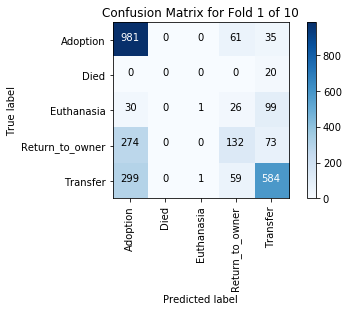

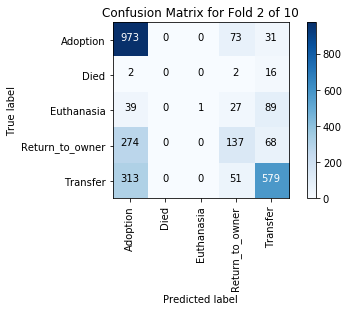

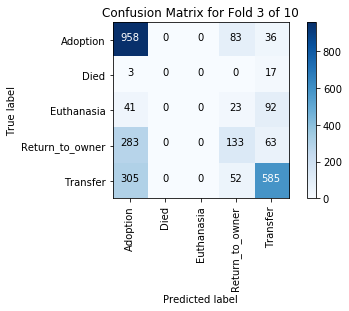

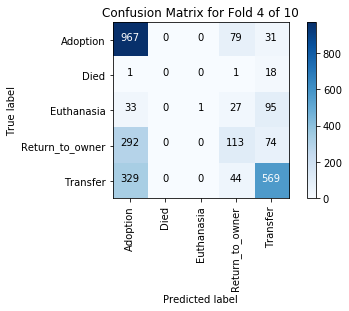

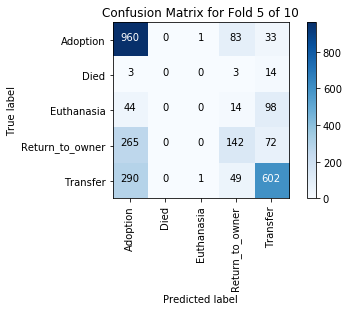

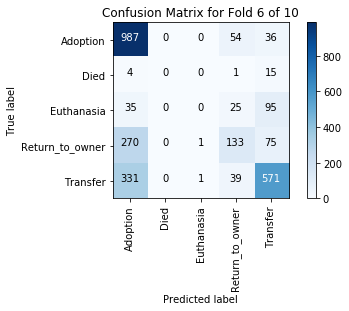

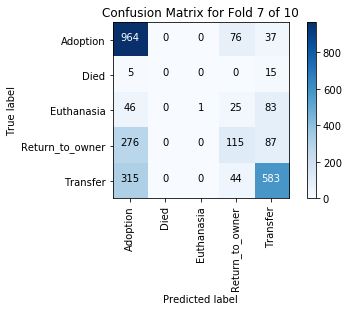

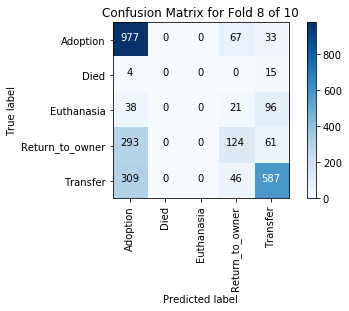

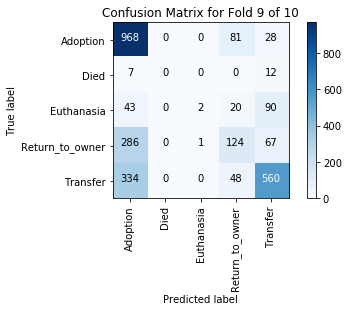

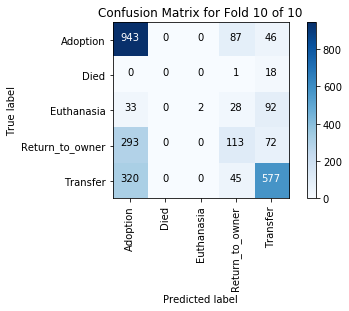

In [52]:
features = ['AnimalType', 'Sex', 'Genitals', 'AgeInDays']
target_names = sort(df.OutcomeType.unique())

def train_with_logistic_regression(train, validate, target_names, 
                                   features, use_class_weight=False,
                                   show_results = True):
    avg_log_loss_train = 0
    avg_log_loss_validate = 0
    for i in range(len(train)):
        X_train = pd.get_dummies(train[i].loc[:, features])
        X_validate = pd.get_dummies(validate[i].loc[:, features])

        weights=None
        if use_class_weight:
            weights = 'balanced'
#             outcome = pd.Categorical(train[i].OutcomeType)
#             t_codes = outcome.codes
#             weights = len(X_train) / (len(features) * np.bincount(t_codes))
#             weights = dict([(outcome.categories[i], weights[i]) 
#                             for i in range(len(outcome.categories))])

        classifier = LogisticRegression(class_weight=weights)     
        classifier.fit(X_train, train[i].OutcomeType)
        t_train = classifier.predict(X_train)
        t_validate = classifier.predict(X_validate)
        
        # need to set categories from full dataset incase some are missing
        # otherwise the vectors won't be of the same size and I won't have to
        # do what was done here before by manually adding the missing categories.
        t_train = pd.Categorical(t_train, categories=target_names)
        t_validate = pd.Categorical(t_validate, categories=target_names)
    
        if show_results:
            print('Fold {0} of {1}:'.format(i+1, len(train)))

        k1_train = pd.get_dummies(t_train)
        k1_validate = pd.get_dummies(t_validate)
        k1_train = k1_train.reindex_axis(sorted(k1_train.columns), axis=1)
        k1_validate = k1_validate.reindex_axis(sorted(k1_validate.columns), axis=1)
        log_loss_train = log_loss(pd.get_dummies(train[i].OutcomeType), k1_train)
        log_loss_validate = log_loss(pd.get_dummies(validate[i].OutcomeType), k1_validate)
        
        if show_results:
            print('Train log loss:', log_loss_train)
            print('Validate log loss:', log_loss_validate)
        avg_log_loss_train += log_loss_train
        avg_log_loss_validate += log_loss_validate

        if show_results:
            print(classification_report(validate[i].OutcomeType.tolist(), 
                                        t_validate, target_names=target_names))

            cm = confusion_matrix(validate[i].OutcomeType.tolist(),
                                  t_validate, labels=target_names)
            plot_confusion_matrix(
                cm, target_names,
                title='Confusion Matrix for Fold {0} of {1}'.format(i+1, len(train)))
    avg_log_loss_train /= len(train)
    avg_log_loss_validate /= len(validate)
    if show_results:
        print('Avg. train log loss:', avg_log_loss_train)
        print('Avg. validate log loss:', avg_log_loss_validate) 
    return (avg_log_loss_train, avg_log_loss_validate)
          
train_with_logistic_regression(train, validate, target_names, features);

This doesn't look too good as we have a lot of misclassifications and it has very poor results predicting any died and euthanasia  cases (although these cases are represented in lower quantities in the data). The variation between folds doesn't look too bad as far as I can tell. This is better than random guessing or guessing the most common outcome (adoption). One simple thing that we can do to start gettting Kaggle to evaluate our results is to train the model on the entire training dataset and then see how well we score on the supplied test data. Hopefully this will do a little better on died/euthanasia cases as it will have more data to work with, but later we probably should look into some sort of bagging method to utilize these folds.

In [53]:
test = pd.read_csv('test.csv', compression='gzip')

test['Sex'] = test.SexuponOutcome.apply(extract_sex)
test['Genitals'] = test.SexuponOutcome.apply(extract_genitals)
test['AgeInDays'] = test.AgeuponOutcome.map(convert_to_AgeInDays)
test.AgeInDays = imputer.fit_transform(pd.get_dummies(test.loc[:, ['AgeInDays']]))

test.AgeInDays = imputer.fit_transform(pd.get_dummies(test.loc[:, ['AgeInDays']]))
def make_predictions(df, test, features, class_weight=None):
    classifier = LogisticRegression(class_weight=class_weight)
    X_train = imputer.fit_transform(pd.get_dummies(df.loc[:, features]))
    X_test = imputer.fit_transform(pd.get_dummies(test.loc[:, features]))
    
    classifier.fit(X_train, df.OutcomeType)
    t_predicted = classifier.predict(X_test)
    
    t_predicted = pd.Categorical(t_predicted, categories=df.OutcomeType.unique())
    submission = pd.get_dummies(t_predicted)
    submission = submission.reindex_axis(sorted(submission.columns), axis=1)   
    submission.insert(0, 'ID', 0)
    submission.ID = test.ID
    return submission

submission = make_predictions(df, test, features)
ICD.display(submission.head())

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0,0,0,0,1
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,0,0,0,0,1
4,5,1,0,0,0,0


In [54]:
def write_submission(submission):
    submission.to_csv('submission.csv', index=False)
    
write_submission(submission)

So this initial submission had a resulting log loss of 12.54201, which is not good (bottom 12% judging by the current leaderboard), but at least better than a naive classier predicting every animal has been adopted (log loss of 20.25113, bottome 3%). One quick and easy thing we can do is to include the name field by simply seeing if the animal having a name matters.

Fold 1 of 10:
Train log loss: 12.8195807622
Validate log loss: 12.537253039
                 precision    recall  f1-score   support

       Adoption       0.62      0.91      0.74      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.33      0.02      0.04       156
Return_to_owner       0.51      0.29      0.37       479
       Transfer       0.72      0.62      0.67       943

    avg / total       0.61      0.64      0.60      2675



/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 2 of 10:
Train log loss: 12.7980424881
Validate log loss: 12.653458268
                 precision    recall  f1-score   support

       Adoption       0.61      0.90      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.38      0.02      0.04       156
Return_to_owner       0.49      0.29      0.37       479
       Transfer       0.74      0.62      0.67       943

    avg / total       0.62      0.63      0.60      2675

Fold 3 of 10:
Train log loss: 12.7788447273
Validate log loss: 12.8261050711
                 precision    recall  f1-score   support

       Adoption       0.61      0.89      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.56      0.03      0.06       156
Return_to_owner       0.47      0.28      0.35       479
       Transfer       0.73      0.62      0.67       942

    avg / total       0.62      0.63      0.59      2674

Fold 4 of 10:
Train log loss: 12.771665601


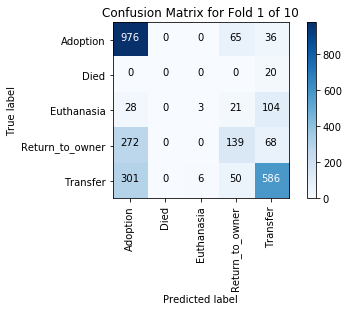

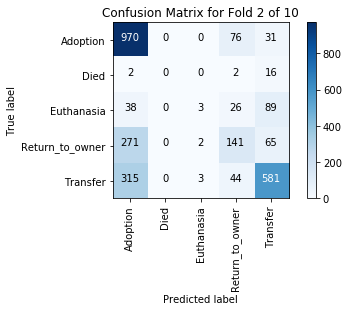

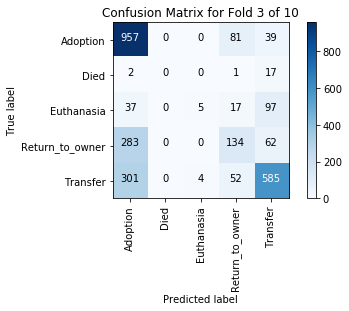

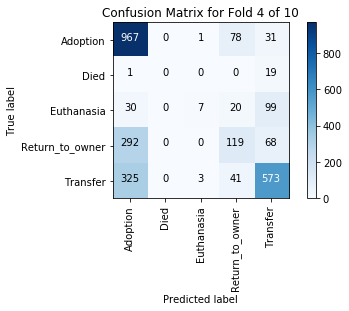

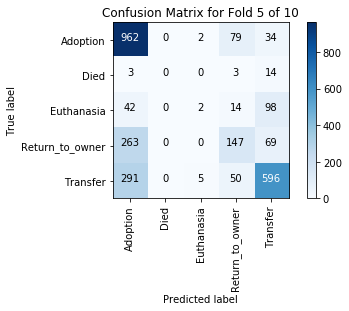

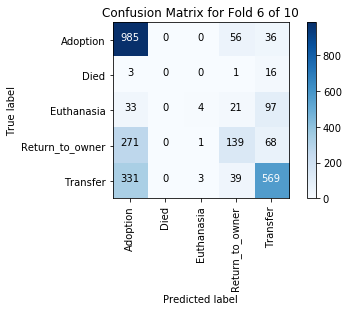

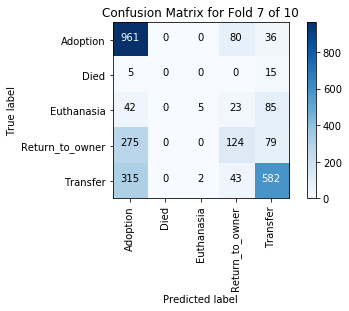

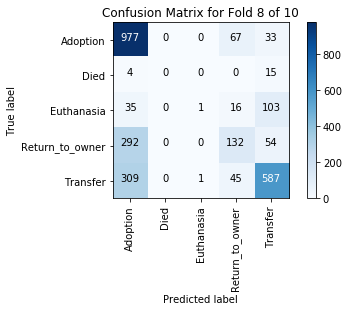

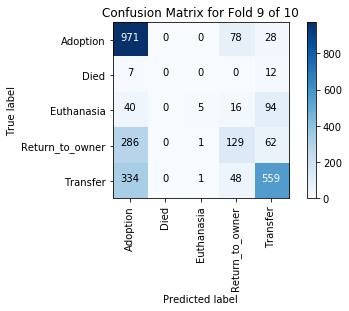

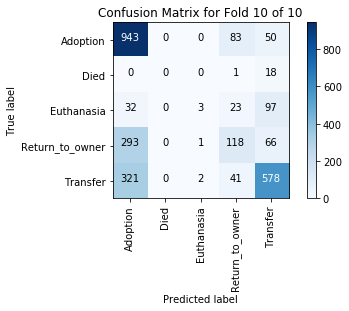

In [55]:
def has_name (x): return 0 if not x else x is not np.nan

df['HasName'] = df.Name.map(has_name)

train, validate = create_train_validate_sets(df, n_folds)
features = ['AnimalType', 'Sex', 'Genitals', 'AgeInDays', 'HasName']
train_with_logistic_regression(train, validate, target_names, features);

It does look like the euthanasia predictions were imporved slightly as was overall F1 score. But only slightly. Let's see the benefit of adding the *HasName* feature makes on the Kaggle test data.

In [56]:
test['HasName'] = test.Name.map(has_name)

write_submission(make_predictions(df, test, features))

The improvement? Log loss of 12.43950 is a bit better than 12.54201, just like the slightly better euthanasia predictions and F1 scores. But only slightly. So I guess I'll want to see a bigger improvement in precision, recall, F1, and the confusion matrix before resubmitting again. 

So what about utilizing the *Milestone* feature. Let's go ahead and create the following groupings and also plot the new feature:
1. NewBorn (0-28 days)
1. EarlyCulling (29-35 days) 
1. PrimeAdoption (36-364 days)
1. Youth (1-6 years) 
1. Midlife (7-13) 
1. Old Age (14+)

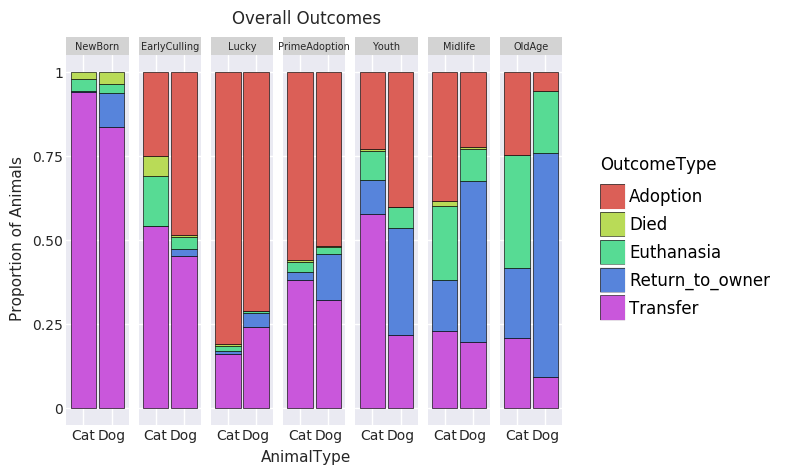

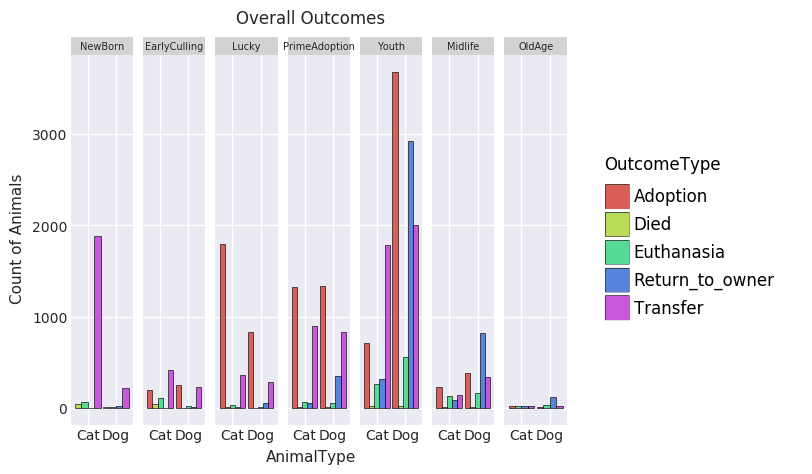

In [57]:
def milestone(x):
    if x <= 28:
        return 'NewBorn'
    elif x > 28 and x <= 35:
        return 'EarlyCulling'
    elif x > 35 and x <= 60:
        return 'Lucky'
    elif x > 60 and x < 365:
        return 'PrimeAdoption'
    elif x >= 365 and x < 7 * 365:
        return 'Youth'
    elif x >= 7 * 356 and x < 14 * 365:
        return 'Midlife'
    else:
        return 'OldAge'
    
    
df['Milestone'] = df.AgeInDays.map(milestone)
#giving categories so it's sorted in order of age
df.Milestone = pd.Categorical(df.Milestone, categories=[
    'NewBorn', 'EarlyCulling', 'Lucky', 'PrimeAdoption', 'Youth', 'Midlife', 'OldAge'])

for position, label in [('fill', 'Proportion'), ('dodge', 'Count')]:
    (ggplot(df, aes(x = 'AnimalType', fill = 'OutcomeType'))
     + geom_bar(position = position, color = 'black', size=.25)
     + facet_grid('. ~ Milestone')
     + labs(y = '{} of Animals'.format(label), title ='Overall Outcomes')
     + theme_seaborn()
     + theme(strip_text_x = element_text(size = 7))
    ).draw()

Hmm, the "EarlyCulling" Period seems to only affect cats, Not sure how helpful this is, but le'ts take a look. Also I went back and added log loss to the analysis so we can better predict how the test data will score on Kaggle and it looks like we get a little better compared to before. I also played with class weights here to try and capture some of the died category because it's so rare (and without balancing the weights it won't capture). Also it won't capture without using the *Milestone* field so there must be some benefit to making this feature. However, we also get a lot of misclassifications trying to use class weights and our log loss increases (into the 13s instead of 12s). So this doesn't seem to be too helpful.

Fold 1 of 10:
Train log loss: 12.5553779329
Validate log loss: 12.3306659653
                 precision    recall  f1-score   support

       Adoption       0.63      0.88      0.74      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.50      0.06      0.10       156
Return_to_owner       0.49      0.34      0.40       479
       Transfer       0.72      0.64      0.68       943

    avg / total       0.63      0.64      0.61      2675



/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 2 of 10:
Train log loss: 12.576916207
Validate log loss: 12.4081361179
                 precision    recall  f1-score   support

       Adoption       0.62      0.88      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.38      0.02      0.04       156
Return_to_owner       0.49      0.34      0.40       479
       Transfer       0.75      0.63      0.69       943

    avg / total       0.62      0.64      0.61      2675

Fold 3 of 10:
Train log loss: 12.5318827842
Validate log loss: 12.5419416154
                 precision    recall  f1-score   support

       Adoption       0.62      0.87      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.64      0.04      0.08       156
Return_to_owner       0.46      0.33      0.38       479
       Transfer       0.73      0.63      0.68       942

    avg / total       0.63      0.64      0.61      2674

Fold 4 of 10:
Train log loss: 12.5347544347

(12.554282308103568, 12.558829288005517)

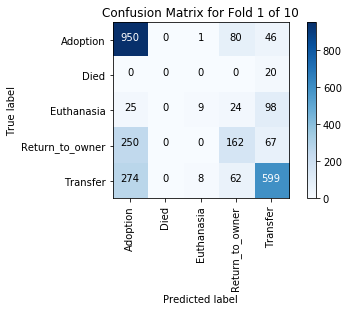

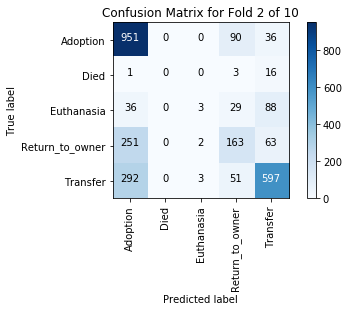

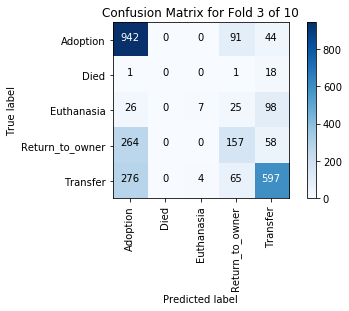

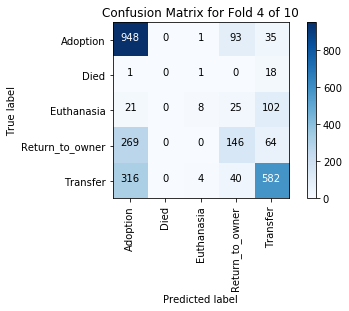

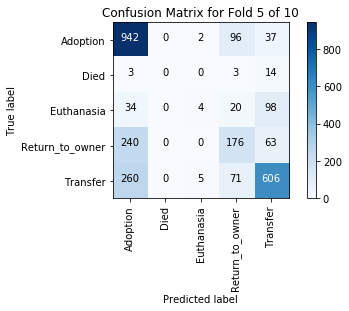

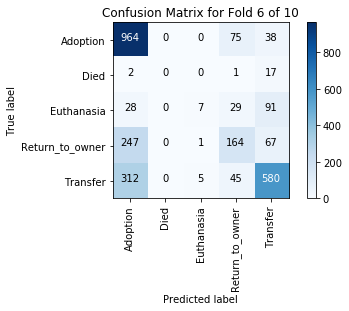

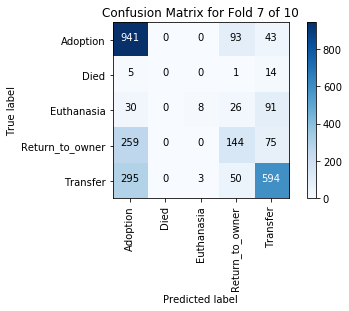

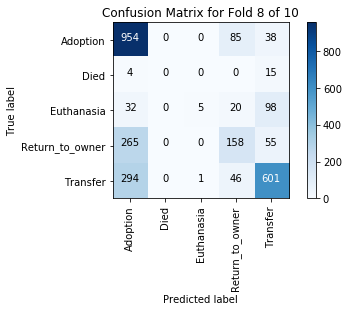

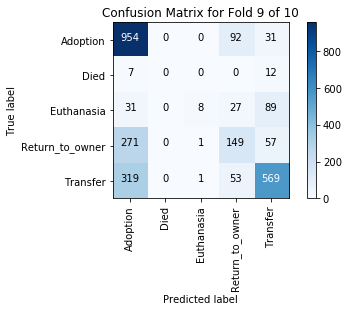

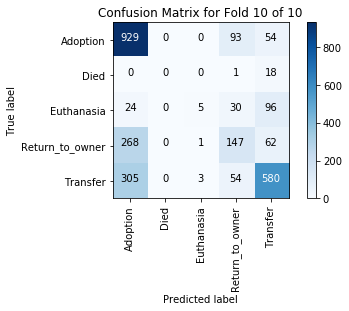

In [58]:
train, validate = create_train_validate_sets(df, n_folds)
features = ['AnimalType', 'Sex', 'Genitals', 'HasName', 'Milestone', 'AgeInDays']
train_with_logistic_regression(train, validate, target_names, features, 
                               use_class_weight=False, show_results=True)

In [59]:
test['Milestone'] = test.AgeInDays.map(milestone)
write_submission(make_predictions(df, test, features))

With balanced class weights and the milestone feature we went from a log loss on the kaggle hold out test data of 12.43950 to 13.44347. But leaving the weights alone we get down to 12.33097 instead (as expected in the log loss calculations on the folds). So *Milestone* helps some, but balanced weighting does not.

In [60]:
# I thought I could also have done this on the existing AgeuponOutcome, but
# imputer doesn't work on it (I tried). besides it might be useful to have this as a
# categorical potentially instead of (or in addition to) the continuous version (AgeInDays) 
# considering it was collected in a chucnked/categorical way of sorts.
column_names = sort(df.AgeInDays.astype(int).unique())
df['AgeInDaysCategorical'] = pd.Categorical(df.AgeInDays.astype(int), categories = column_names)
    

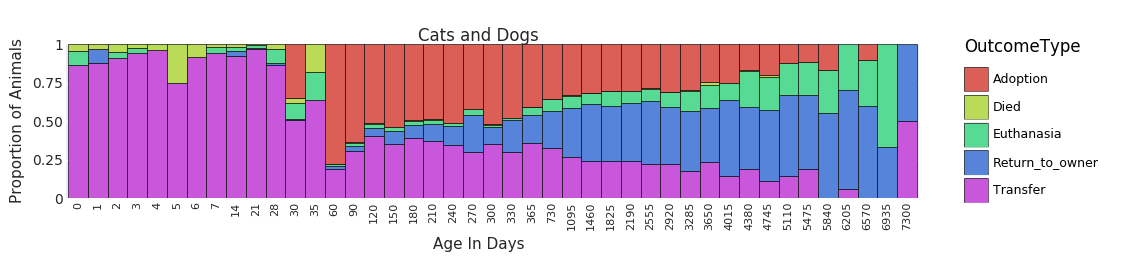

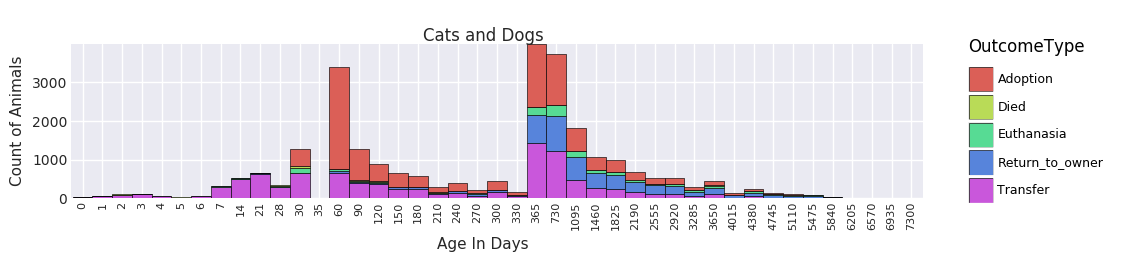

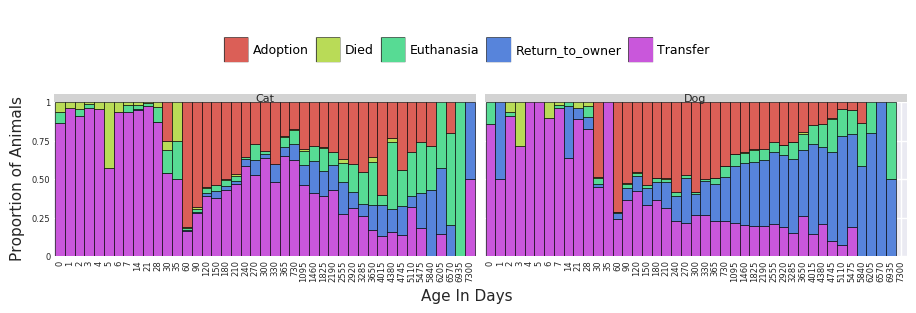

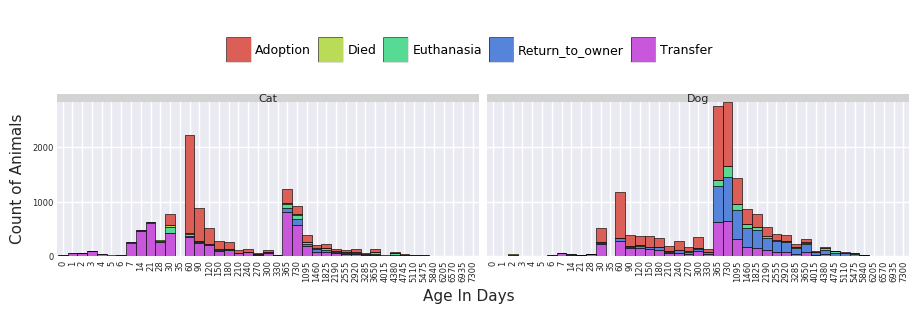

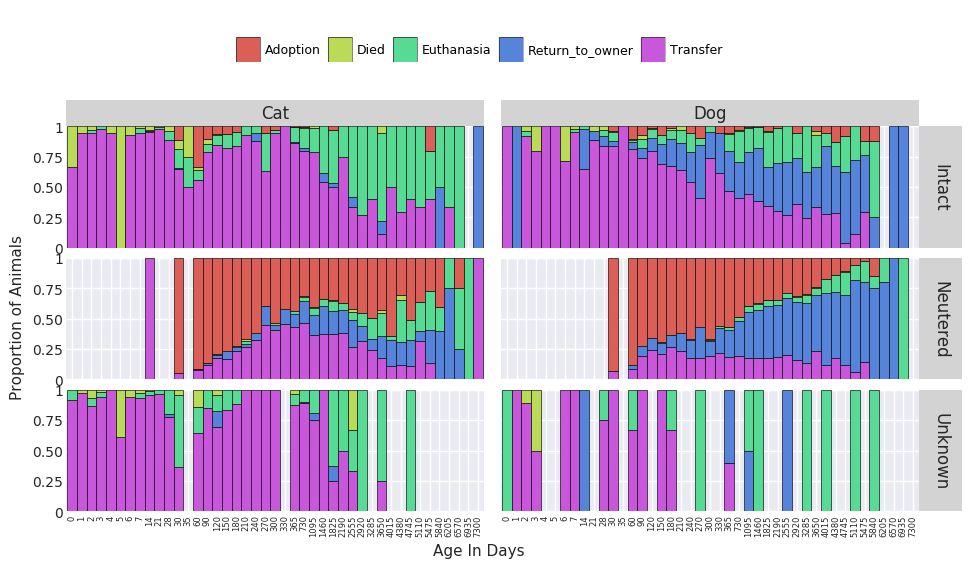

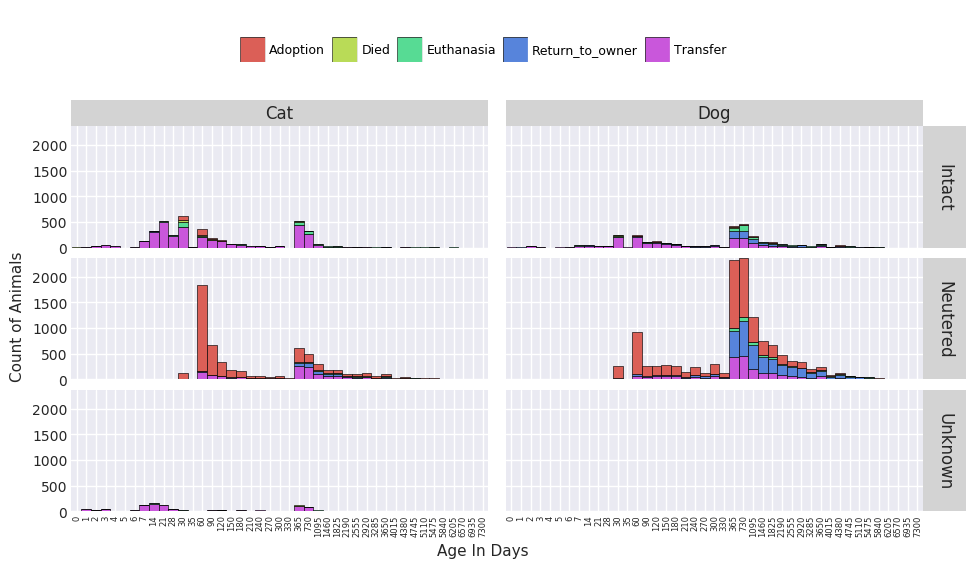

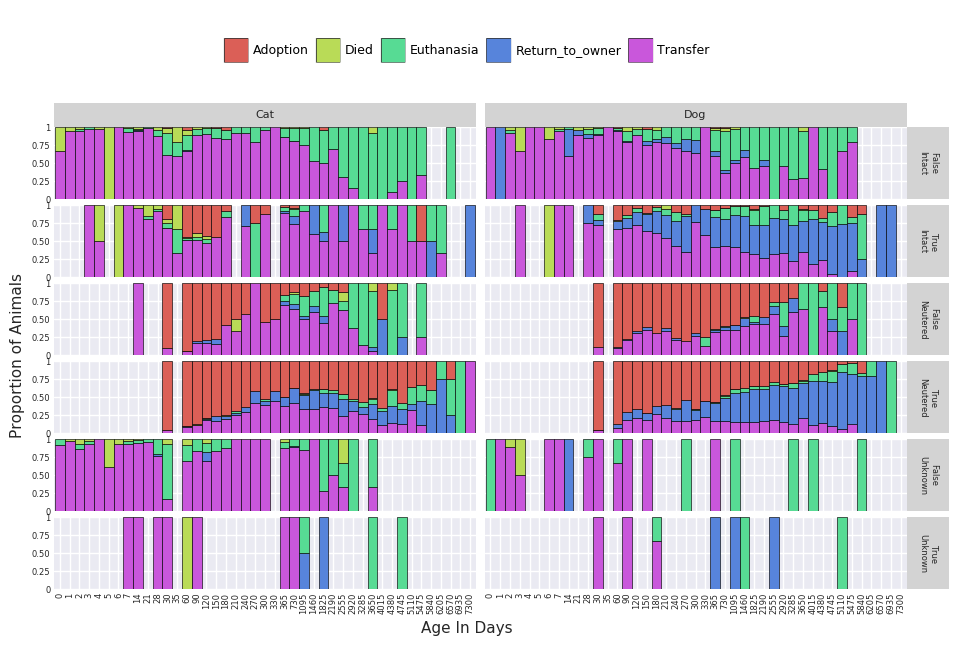

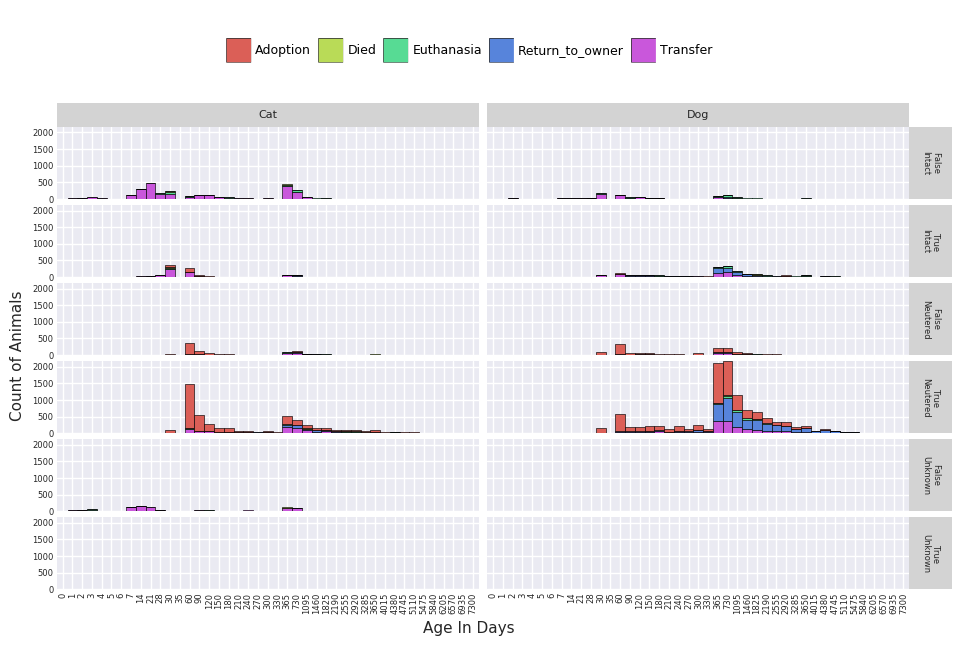

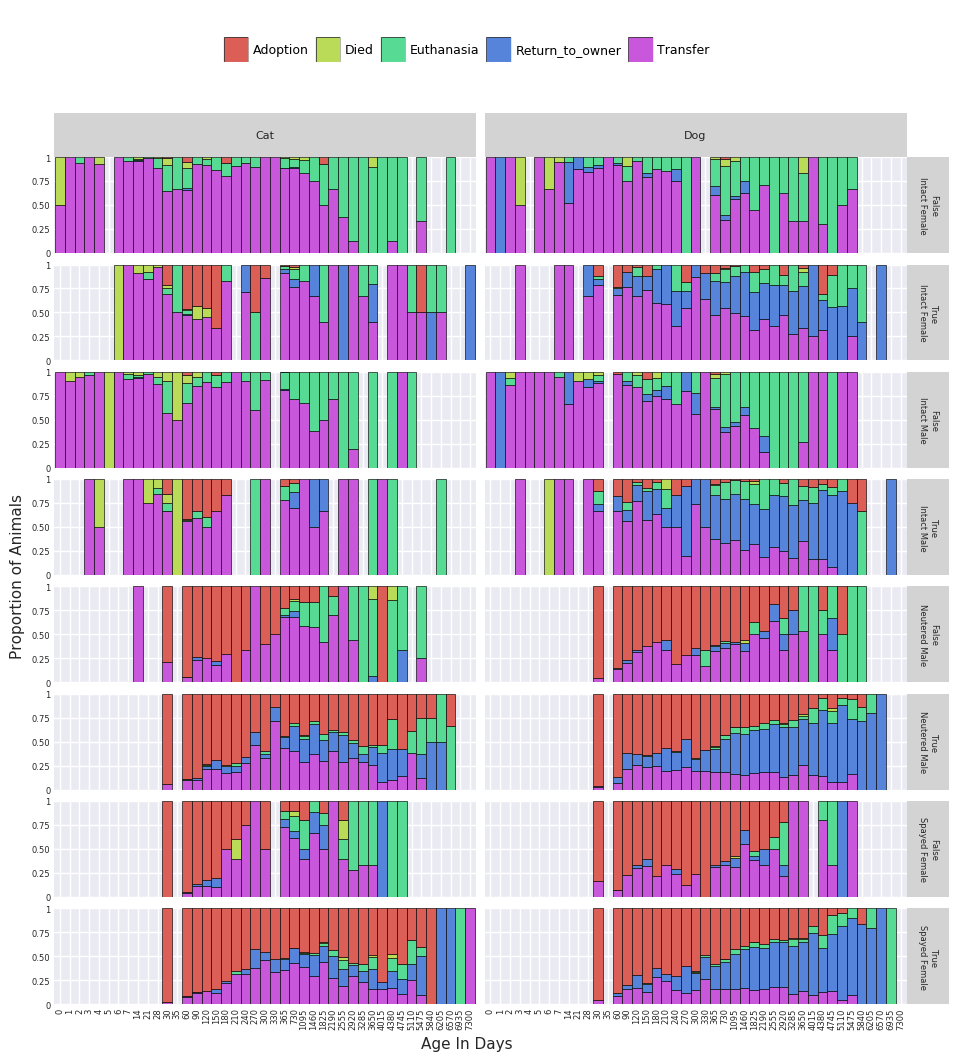

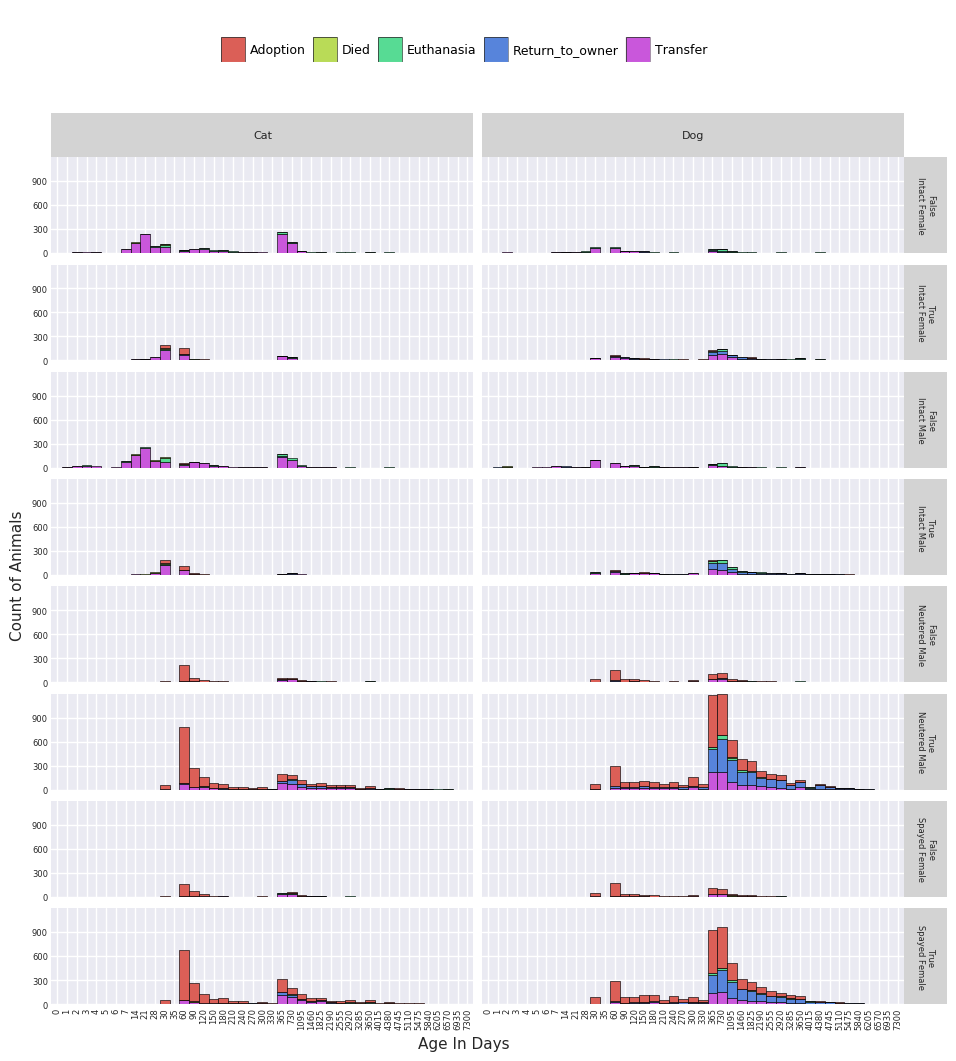

In [28]:
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p = (ggplot(df, aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label), title = 'Cats and Dogs')
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 8),
             panel_grid_minor = element_blank(),
             legend_text=element_text(size=9))
    )
    p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11, 2)
    
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p = (ggplot(df, aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)     
     + facet_grid('. ~ AnimalType')
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label))
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 6),
             axis_text_y = element_text(size = 6),
             strip_text_x = element_text(size = 8),
             panel_grid_minor = element_blank(),
             legend_position = 'top',
             panel_spacing = 0.05,
             legend_title = element_blank(),
             legend_text=element_text(size=9))
    )
    p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11,2)
    
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p =(ggplot(df, aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)     
     + facet_grid('Genitals ~ AnimalType')
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label))
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 6),
             panel_grid_minor = element_blank(),
             legend_text=element_text(size=9),
             legend_position = 'top',
             legend_title = element_blank())
    )
    p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11,5)
    
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p = (ggplot(df, aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)     
     + facet_grid('Genitals + HasName ~ AnimalType')
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label))
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 6),
             axis_text_y = element_text(size = 6),
             panel_grid_minor = element_blank(),
             legend_position = 'top',
             panel_spacing = 0.05,
             legend_title = element_blank(),
             strip_text_x = element_text(size = 8),             
             strip_text_y = element_text(size = 6),
             legend_text=element_text(size=9))
    )
    p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11,6)
    
# Unknown captured above so don't need to "zoom" in here
for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    p = (ggplot(df[df.SexuponOutcome != 'Unknown'], aes(x = 'AgeInDaysCategorical', fill = 'OutcomeType'))
     + geom_bar(position = position, width=1, color='black', size=0.25)     
     + facet_grid('SexuponOutcome + HasName ~ AnimalType')
     + labs(x = 'Age In Days', y = '{} of Animals'.format(label))
     + coord_cartesian(ylim=[0, 1])
     + theme_seaborn()
     + theme(axis_text_x = element_text(angle = 90, size = 6),
             axis_text_y = element_text(size = 6),
             panel_grid_minor = element_blank(),
             legend_position = 'top',
             panel_spacing = 0.05,
             legend_title = element_blank(),
             legend_text=element_text(size=9),
             strip_text_x = element_text(size = 8),
             strip_text_y = element_text(size = 6))
    )
    p += scale_y_continuous(expand = [0,0])
    p.draw().set_size_inches(11,11)

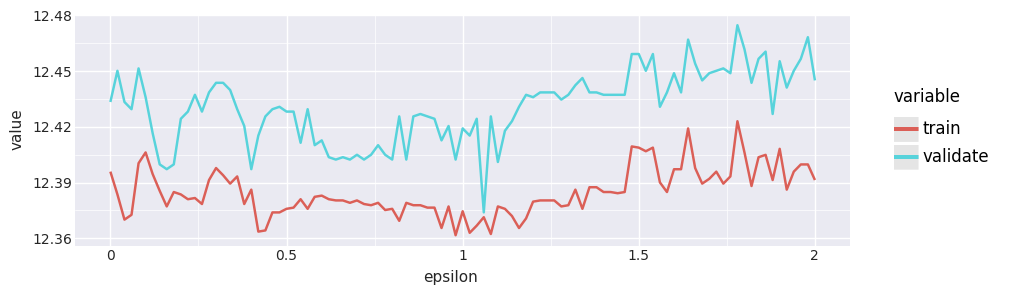

In [30]:
from multiprocessing import Pool

def mimic_continuous(x, epsilon):
    x += random.RandomState(12345).uniform(x * (1 - epsilon) - x, 
                                           x * (1 + epsilon) - x)
    return 0 if x < 0 else x

def iteration(i):
    df['AgeInDaysNoisy'] = df.AgeInDays.apply(mimic_continuous, epsilon = i/100)
    train, validate = create_train_validate_sets(df, 3)
    features = ['AnimalType', 'Sex', 'Genitals', 'HasName', 'Milestone', 
                'AgeInDaysCategorical', 'AgeInDaysNoisy']
    (t, v) = train_with_logistic_regression(
        train, validate, target_names, features, 
        use_class_weight=False, show_results=False)
    return (i/100, t, v)

stop, step = 200, 2
range_ = range(0, stop+step, step)
p = Pool(processes=8)
result = p.map(iteration, range_)

ln_loss = pd.DataFrame(result, columns=['epsilon', 'train','validate'])
ln_loss = pd.melt(ln_loss, id_vars=['epsilon'], value_vars=['train', 'validate'])

(ggplot(ln_loss, aes(x='epsilon', y='value', color='variable'))
 + geom_line(size=1)
 + theme_seaborn()
 + theme(panel_grid_minor = element_line(size=0.5))
).draw().set_size_inches(10, 3)

Fold 1 of 10:
Train log loss: 12.3888152796
Validate log loss: 12.2015490442
                 precision    recall  f1-score   support

       Adoption       0.65      0.85      0.74      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.50      0.06      0.10       156
Return_to_owner       0.48      0.43      0.45       479
       Transfer       0.73      0.64      0.68       943

    avg / total       0.63      0.65      0.62      2675



/Users/mattspinnelli/anaconda3/envs/627py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 2 of 10:
Train log loss: 12.4204047483
Validate log loss: 12.0724321231
                 precision    recall  f1-score   support

       Adoption       0.65      0.85      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.55      0.04      0.07       156
Return_to_owner       0.48      0.44      0.46       479
       Transfer       0.75      0.64      0.69       943

    avg / total       0.64      0.65      0.63      2675

Fold 3 of 10:
Train log loss: 12.3768136572
Validate log loss: 12.3611103253
                 precision    recall  f1-score   support

       Adoption       0.65      0.84      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.60      0.04      0.07       156
Return_to_owner       0.47      0.43      0.45       479
       Transfer       0.73      0.64      0.68       942

    avg / total       0.64      0.64      0.62      2674

Fold 4 of 10:
Train log loss: 12.358147929

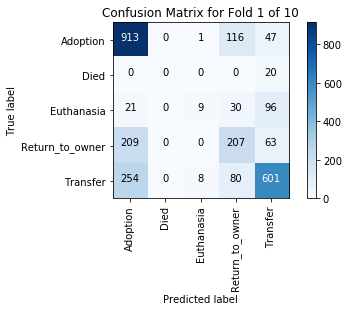

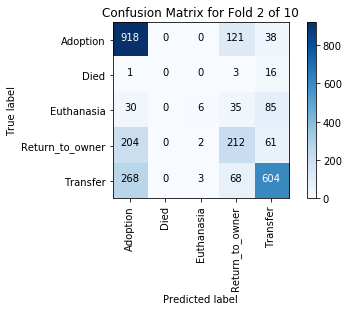

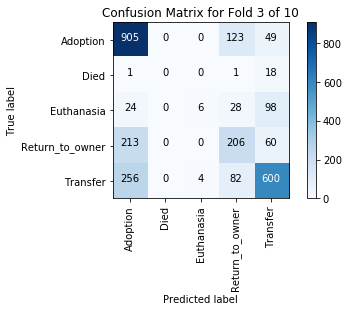

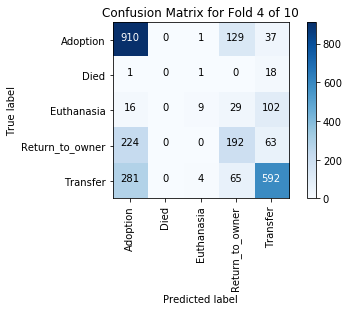

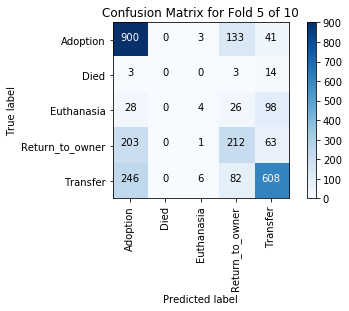

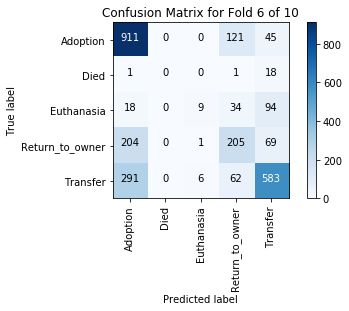

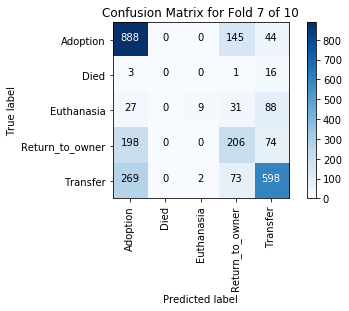

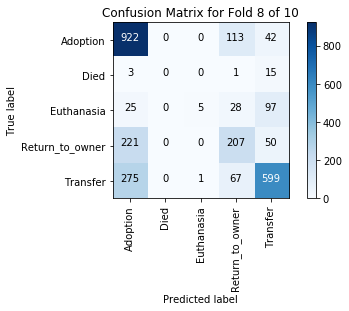

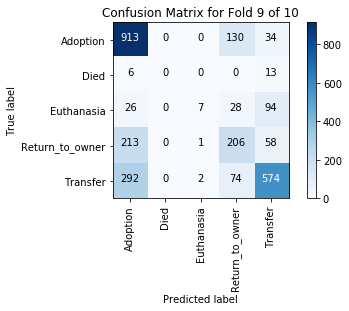

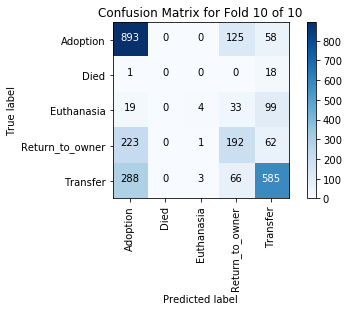

In [61]:
df['AgeInDaysNoisy'] = df.AgeInDays.apply(mimic_continuous, epsilon = 0.66)
train, validate = create_train_validate_sets(df, 10)
features = ['AnimalType', 'Sex', 'Genitals', 'HasName', 'Milestone', 
            'AgeInDaysCategorical', 'AgeInDaysNoisy']
train_with_logistic_regression(
    train, validate, target_names, features, use_class_weight=False, show_results=True);

In [32]:
test['AgeInDaysCategorical'] = pd.Categorical(test.AgeInDays.astype(int), categories = column_names)
test['AgeInDaysNoisy'] = test.AgeInDays.apply(mimic_continuous, epsilon = 0.66)
write_submission(make_predictions(df, test, features))

 Time to look at the Dates and Times.

In [69]:
from datetime import datetime
from mizani.breaks import date_breaks
df['Date'] = df.DateTime.map(
    lambda x: x if x is nan else datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
df['Time'] = df.DateTime.map(
    lambda x: x if x is nan else datetime.strptime(str(x).split(' ')[1], '%H:%M:%S'))

for position, label in [('fill', 'Proportion'), ('stack', 'Count')]:
    (ggplot(df, aes(x = 'Date', fill ='OutcomeType'))
     + geom_area(stat='bin', bins=100, position = position)
     + geom_line(aes(ymax='Date', position = position))
     + labs(y = '{} of Animals'.format(label))
     + theme_seaborn()
     + theme(legend_position = 'top')
     + scale_x_datetime(breaks = date_breaks("1 Month"))
     + theme(axis_text_x = element_text(angle = 90, size = 8))
    ).draw().set_size_inches(10, 5)

IndexError: list index out of range